In [ ]:
import xarray as xr
import pandas as pd
import proplot as pplt
import numpy as np
import pyproj
import os
import sys
sys.path.append('/Users/dwatkin2/Documents/research/packages/buoy_processing/drifter')
import utilities.analysis as anls



This notebook has the code for making the 3x3; adapt this to a script and then add the wind data as an overlay. It also has the script for calculating the storm track.

In [2]:
ds_slp = xr.open_dataset('../data/era5/era5_slp_2020.nc')
ds_tuv = xr.open_dataset('../data/era5/era5_tuv_pl_janfeb.nc')
ds_q = xr.open_dataset('../data/era5/era5_q_pl_janfeb.nc')
ds_uv = xr.open_dataset('../data/era5/era5_uv_2020.nc')
dates = pd.date_range('2020-01-31 00:00', '2020-02-02 18:00', freq='6H')

lonmesh, latmesh = np.meshgrid(ds_slp.longitude, ds_slp.latitude)


In [3]:
pol_stere_proj = 'epsg:3413'
npstere_crs = pyproj.CRS(pol_stere_proj)
source_crs = pyproj.CRS("epsg:4326") # Global lat-lon coordinate system
latlon_to_polar = pyproj.Transformer.from_crs(source_crs, npstere_crs, always_xy=True)
polar_to_latlon = pyproj.Transformer.from_crs(npstere_crs, source_crs, always_xy=True)


X, Y = latlon_to_polar.transform(lonmesh, latmesh)

In [4]:
import metpy.calc as mcalc
from metpy.units import units

dwp = mcalc.dewpoint_from_specific_humidity(pressure = 925*units('hPa'),
                                            temperature = ds_tuv['t'].sel(level=925).data * units('K'),
                                            specific_humidity = ds_q['q'].sel(level=925).data * units('kg/kg'))

theta_e = mcalc.equivalent_potential_temperature(pressure = 925 * units('hPa'),
                                       temperature = ds_tuv['t'].sel(level=925).data * units('K'),
                                       dewpoint = dwp)

ds_dwp = xr.Dataset({'td': (('time', 'latitude', 'longitude'), dwp.magnitude)},
                    coords={'time': ds_tuv.time,
                          'latitude': ds_tuv.latitude,
                          'longitude': ds_tuv.longitude})

ds_theta = xr.Dataset({'theta_e': (('time', 'latitude', 'longitude'), theta_e.magnitude)},
                    coords={'time': ds_tuv.time,
                          'latitude': ds_tuv.latitude,
                          'longitude': ds_tuv.longitude})

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/metpy/calc/thermo.py:1341: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


In [12]:
# Storm track
longitude_orig = ds_slp.longitude.to_numpy()
latitude_orig = ds_slp.latitude.to_numpy()
lon_grid, lat_grid = np.meshgrid(longitude_orig, latitude_orig)
dates = pd.date_range('2020-01-31 00:00', '2020-02-03 10:00', freq='1H')
storm_track = pd.DataFrame(data=np.nan, columns=['longitude', 'latitude', 'center_mslp'], index=dates)
for date in dates:
    if date < pd.to_datetime('2020-02-01 06:00'):
        data_slice = ds_slp.sel(latitude=slice(90, 80)).sel(time=date)
        longitude = data_slice.longitude.to_numpy()
        latitude = data_slice.latitude.to_numpy()
    else:
        data_slice = ds_slp.sel(latitude=slice(90, 60)).isel(longitude=(longitude_orig > 60) | (longitude_orig < -60)
                                                            ).sel(time=date)
        longitude = data_slice.longitude.to_numpy()
        latitude = data_slice.latitude.to_numpy()
        
    x = data_slice['msl'].to_numpy()
    lat_idx, lon_idx = np.where(x==x.min())
    storm_track.loc[date, :] = [longitude[lon_idx[0]], latitude[lat_idx[0]], x.min()]
storm_track['lon_smoothed'] = (storm_track.longitude % 360).rolling(5, center=True).mean()
storm_track['lat_smoothed'] = storm_track.latitude.rolling(5, center=True).mean()
storm_track['msl_smoothed'] = storm_track.center_mslp.rolling(5, center=True).mean()    
x, y = latlon_to_polar.transform(storm_track.lon_smoothed, storm_track.lat_smoothed)
storm_track['x_stere'] = x
storm_track['y_stere'] = y

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: 

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


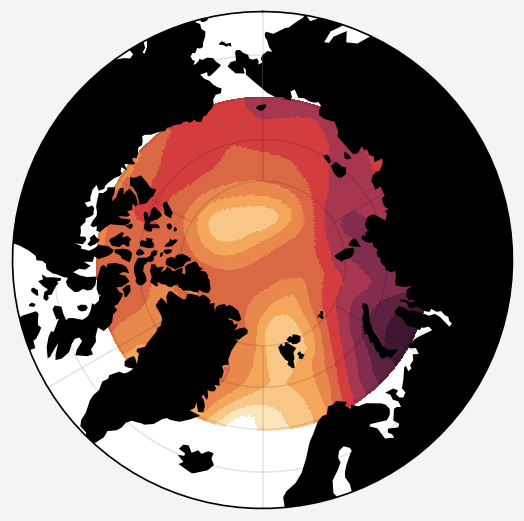

In [13]:
fig, ax = pplt.subplots(proj='npstere')
ax.format(boundinglat=60, land=True)
ax.pcolormesh(ds_slp.sel(time='2020-01-31 0:00')['msl'])

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: 

<a list of 1 Line2D objects>

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


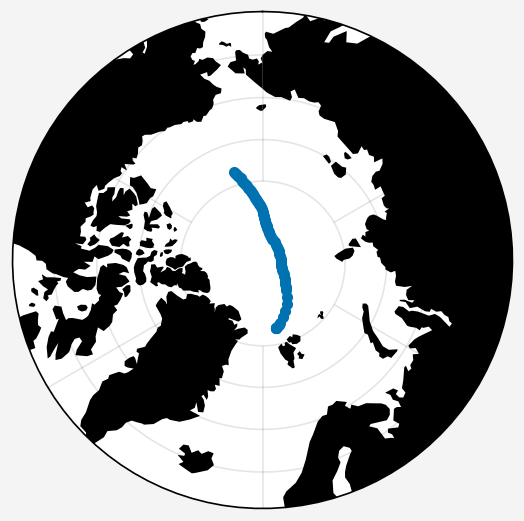

In [22]:
fig, ax = pplt.subplots(proj='npstere')
ax.format(boundinglat=60, land=True)
for idx in range(4):
    storm_track.iloc[idx,:] = storm_track.iloc[4, :]
    storm_track.iloc[idx,:] = storm_track.iloc[4, :]
ax.plot(storm_track['lon_smoothed'], storm_track['lat_smoothed'], marker='.')

In [15]:
storm_track.to_csv('../data/storm_track.csv')

Equivalent potential temperature was calculated using MetPy from ERA5 temperature and specific humidity fields. 
The storm track was identifies by following the local minimum in the hourly ERA5 sea level pressure data and smoothing the result with a 5-hour centered mean. Temperature, wind, pressure, and equivalent potential temperature were then projected onto a polar stereographic grid, and data within 1500 km of the storm track center were selected.

This interpolation is inefficient, since it ignores the grid. Future adjustment could use the built-in xarray method that I learned about recently. 

In [23]:
from scipy.interpolate import LinearNDInterpolator
def dist(x, y, X, Y):
    return np.sqrt((X - x)**2 + (Y-y)**2)

newx, newy = np.meshgrid(np.linspace(-1500e3, 1500e3, 121),
                         np.linspace(-1500e3, 1500e3, 121))
newu, newv = np.meshgrid(np.linspace(-1500e3, 1500e3, 51),
                         np.linspace(-1500e3, 1500e3, 51))


interp_p = {'X': newx, 'Y': newy, 'Z': {}}
interp_u10 = {'X': newu, 'Y': newv, 'Z': {}}
interp_v10 = {'X': newu, 'Y': newv, 'Z': {}}
interp_u925 = {'X': newu, 'Y': newv, 'Z': {}}
interp_v925 = {'X': newu, 'Y': newv, 'Z': {}}
interp_t925 = {'X': newx, 'Y': newy, 'Z': {}}
interp_theta925 = {'X': newx, 'Y': newy, 'Z': {}}
interp_q925 = {'X': newx, 'Y': newy, 'Z': {}}

In [25]:
%%time
dates = pd.date_range('2020-01-31 04:00', '2020-02-02 20:00', freq='1h')
for date in dates:
    xs, ys = storm_track.loc[date, ['x_stere', 'y_stere']] # Storm center
    idx = np.ravel(dist(xs, ys, X, Y) < 1500e3) # Select all within 1500 km
    xsel = np.ravel(X)[idx] - xs # Shift so that storm center is 0
    ysel = np.ravel(Y)[idx] - ys
    
    
    # extract variables
    p = np.ravel(ds_slp['msl'].sel(time=date).to_pandas()/100)[idx]
    t925 = np.ravel(ds_tuv.sel(level=925)['t'].drop('level').sel(
        time=date).to_pandas())[idx]
    theta925 = np.ravel(ds_theta.sel(time=date)['theta_e'].to_pandas())[idx]
    q925 = np.ravel(ds_q.sel(level=925)['q'].drop('level').sel(
        time=date).to_pandas())[idx]
    u = np.ravel(ds_tuv.sel(level=925)['u'].drop('level').sel(
        time=date).to_pandas())[idx]
    v = np.ravel(ds_tuv.sel(level=925)['v'].drop('level').sel(
        time=date).to_pandas())[idx]
    u10 = np.ravel(ds_uv.sel(time=date, latitude=slice(90, 70))['u10'].to_pandas())[idx]
    v10 = np.ravel(ds_uv.sel(time=date, latitude=slice(90,70))['v10'].to_pandas())[idx]
    
    # Rotate winds to polar stereographic 
    # Adding 45 to the longitude here is to match the
    # NSIDC polar stereographic convention of lon_0 = -45
    lon = np.ravel(lonmesh)[idx] + 45
    ustere = u * np.cos(np.deg2rad(lon)) - v * np.sin(np.deg2rad(lon))    
    vstere = u * np.sin(np.deg2rad(lon)) + v * np.cos(np.deg2rad(lon))
    u10stere = u10 * np.cos(np.deg2rad(lon)) - v10 * np.sin(np.deg2rad(lon))    
    v10stere = u10 * np.sin(np.deg2rad(lon)) + v10 * np.cos(np.deg2rad(lon))

    # Interpolate from lat/lon to 10 km grid
    interp_p['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), p)(newx, newy)
#    interp_t925['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), t925)(newx, newy)
    interp_theta925['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), theta925)(newx, newy)    
#    interp_q925['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), q925)(newx, newy)
    interp_u925['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), ustere)(newu, newv)
    interp_v925['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), vstere)(newu, newv)
    interp_u10['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), u10)(newu, newv)
    interp_v10['Z'][date] = LinearNDInterpolator(list(zip(xsel, ysel)), v10)(newu, newv)    

CPU times: user 11min 23s, sys: 17min 54s, total: 29min 18s
Wall time: 21min 10s


In [26]:
import metpy.calc as mpcalc
from metpy.units import units
buoy_data = {}
met_data = {}
metadataloc = '../../../packages/buoy_processing/data/adc_dn_tracks/'
metadata = pd.read_csv(metadataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
metadata.set_index('Sensor ID', inplace=True)
dataloc = '../../../packages/buoy_processing/drifter/data/mosaic_interpolated_v2/'
files = os.listdir(dataloc)
files = [f for f in files if f[0] not in ['.', 'm']]
buoy_data = {f.split('_')[-1].replace('.csv', ''): pd.read_csv(dataloc + f,
            index_col=0, parse_dates=True) for f in files}
full_time_series = [b for b in buoy_data if len(buoy_data[b]) == 277]
station_id = metadata.loc[:, 'DN Station ID']
stations_already = []
truncated_list = []
for buoy in full_time_series:
    if station_id[buoy] not in stations_already:
        stations_already.append(station_id[buoy])
        truncated_list.append(buoy)

lat = pd.Series({buoy: buoy_data[buoy]['latitude'].median() for buoy in truncated_list})
lon = pd.Series({buoy: buoy_data[buoy]['longitude'].median() for buoy in truncated_list})
distant_buoys = lat[(lat < 87) | (lon < 80)].index.tolist()
near_buoys = [b for b in truncated_list if b not in distant_buoys]

for buoy in buoy_data:
    buoy_df = buoy_data[buoy].loc[:, ['latitude', 'longitude']]
    buoy_df = anls.compute_velocity(buoy_df, rotate_uv=True, method='centered', date_index=True)
    buoy_data[buoy]['u'] = buoy_df['u']
    buoy_data[buoy]['v'] = buoy_df['v']
    
    buoy_df = buoy_data[buoy].loc[:, ['latitude', 'longitude']].rolling('12H', center=True).mean()
    buoy_df = anls.compute_velocity(buoy_df, rotate_uv=True, method='centered', date_index=True)
    buoy_data[buoy]['smoothed_u'] = buoy_df['u']
    buoy_data[buoy]['smoothed_v'] = buoy_df['v']
    buoy_data[buoy]['smoothed_speed'] = buoy_df['speed']

for source in ['asfs30', 'asfs40', 'asfs50']:
    met_data[source] = pd.read_csv('../data/met_data/' + source + '.csv', parse_dates=True, index_col=0)
    met_data[source].loc[np.abs(met_data[source]['wspd_u_mean']) > 15, ['wspd_v_mean', 'wspd_u_mean']] = np.nan
    met_data[source].loc[met_data[source]['latitude'] < 0, ['latitude', 'longitude']] = np.nan
    met_data[source]['U'] = np.sqrt(met_data[source]['wspd_u_mean']**2 + met_data[source]['wspd_v_mean']**2)
    met_data[source]['wind_dir'] = mpcalc.wind_direction(
                                u=met_data[source]['wspd_u_mean'].values * units('m/s'),
                                v=met_data[source]['wspd_v_mean'].values * units('m/s'),
                                convention='to').magnitude
    df = anls.compute_velocity(met_data[source].copy(), date_index=True, rotate_uv=True, method='centered')
    met_data[source]['u_ice'] = df['u']
    met_data[source]['v_ice'] = df['v']
    met_data[source]['U_ice'] = df['speed'].where(df['speed'] < 1)
    met_data[source]['ice_dir'] = mpcalc.wind_direction(
                                    u=met_data[source]['u_ice'].values * units('m/s'),
                                    v=met_data[source]['v_ice'].values * units('m/s'),
                                    convention='to').magnitude

for buoy in buoy_data:
    x, y = latlon_to_polar.transform(buoy_data[buoy].longitude, buoy_data[buoy].latitude)
    buoy_data[buoy]['x_stere'] = x
    buoy_data[buoy]['y_stere'] = y

for site in met_data:
    x, y = latlon_to_polar.transform(met_data[site].longitude, met_data[site].latitude)
    met_data[site]['x_stere'] = x
    met_data[site]['y_stere'] = y

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_6898/1669472741.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lat = pd.Series({buoy: buoy_data[buoy]['latitude'].median() for buoy in truncated_list})
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_6898/1669472741.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lon = pd.Series({buoy: buoy_data[buoy]['longitude'].median() for buoy in truncated_list})


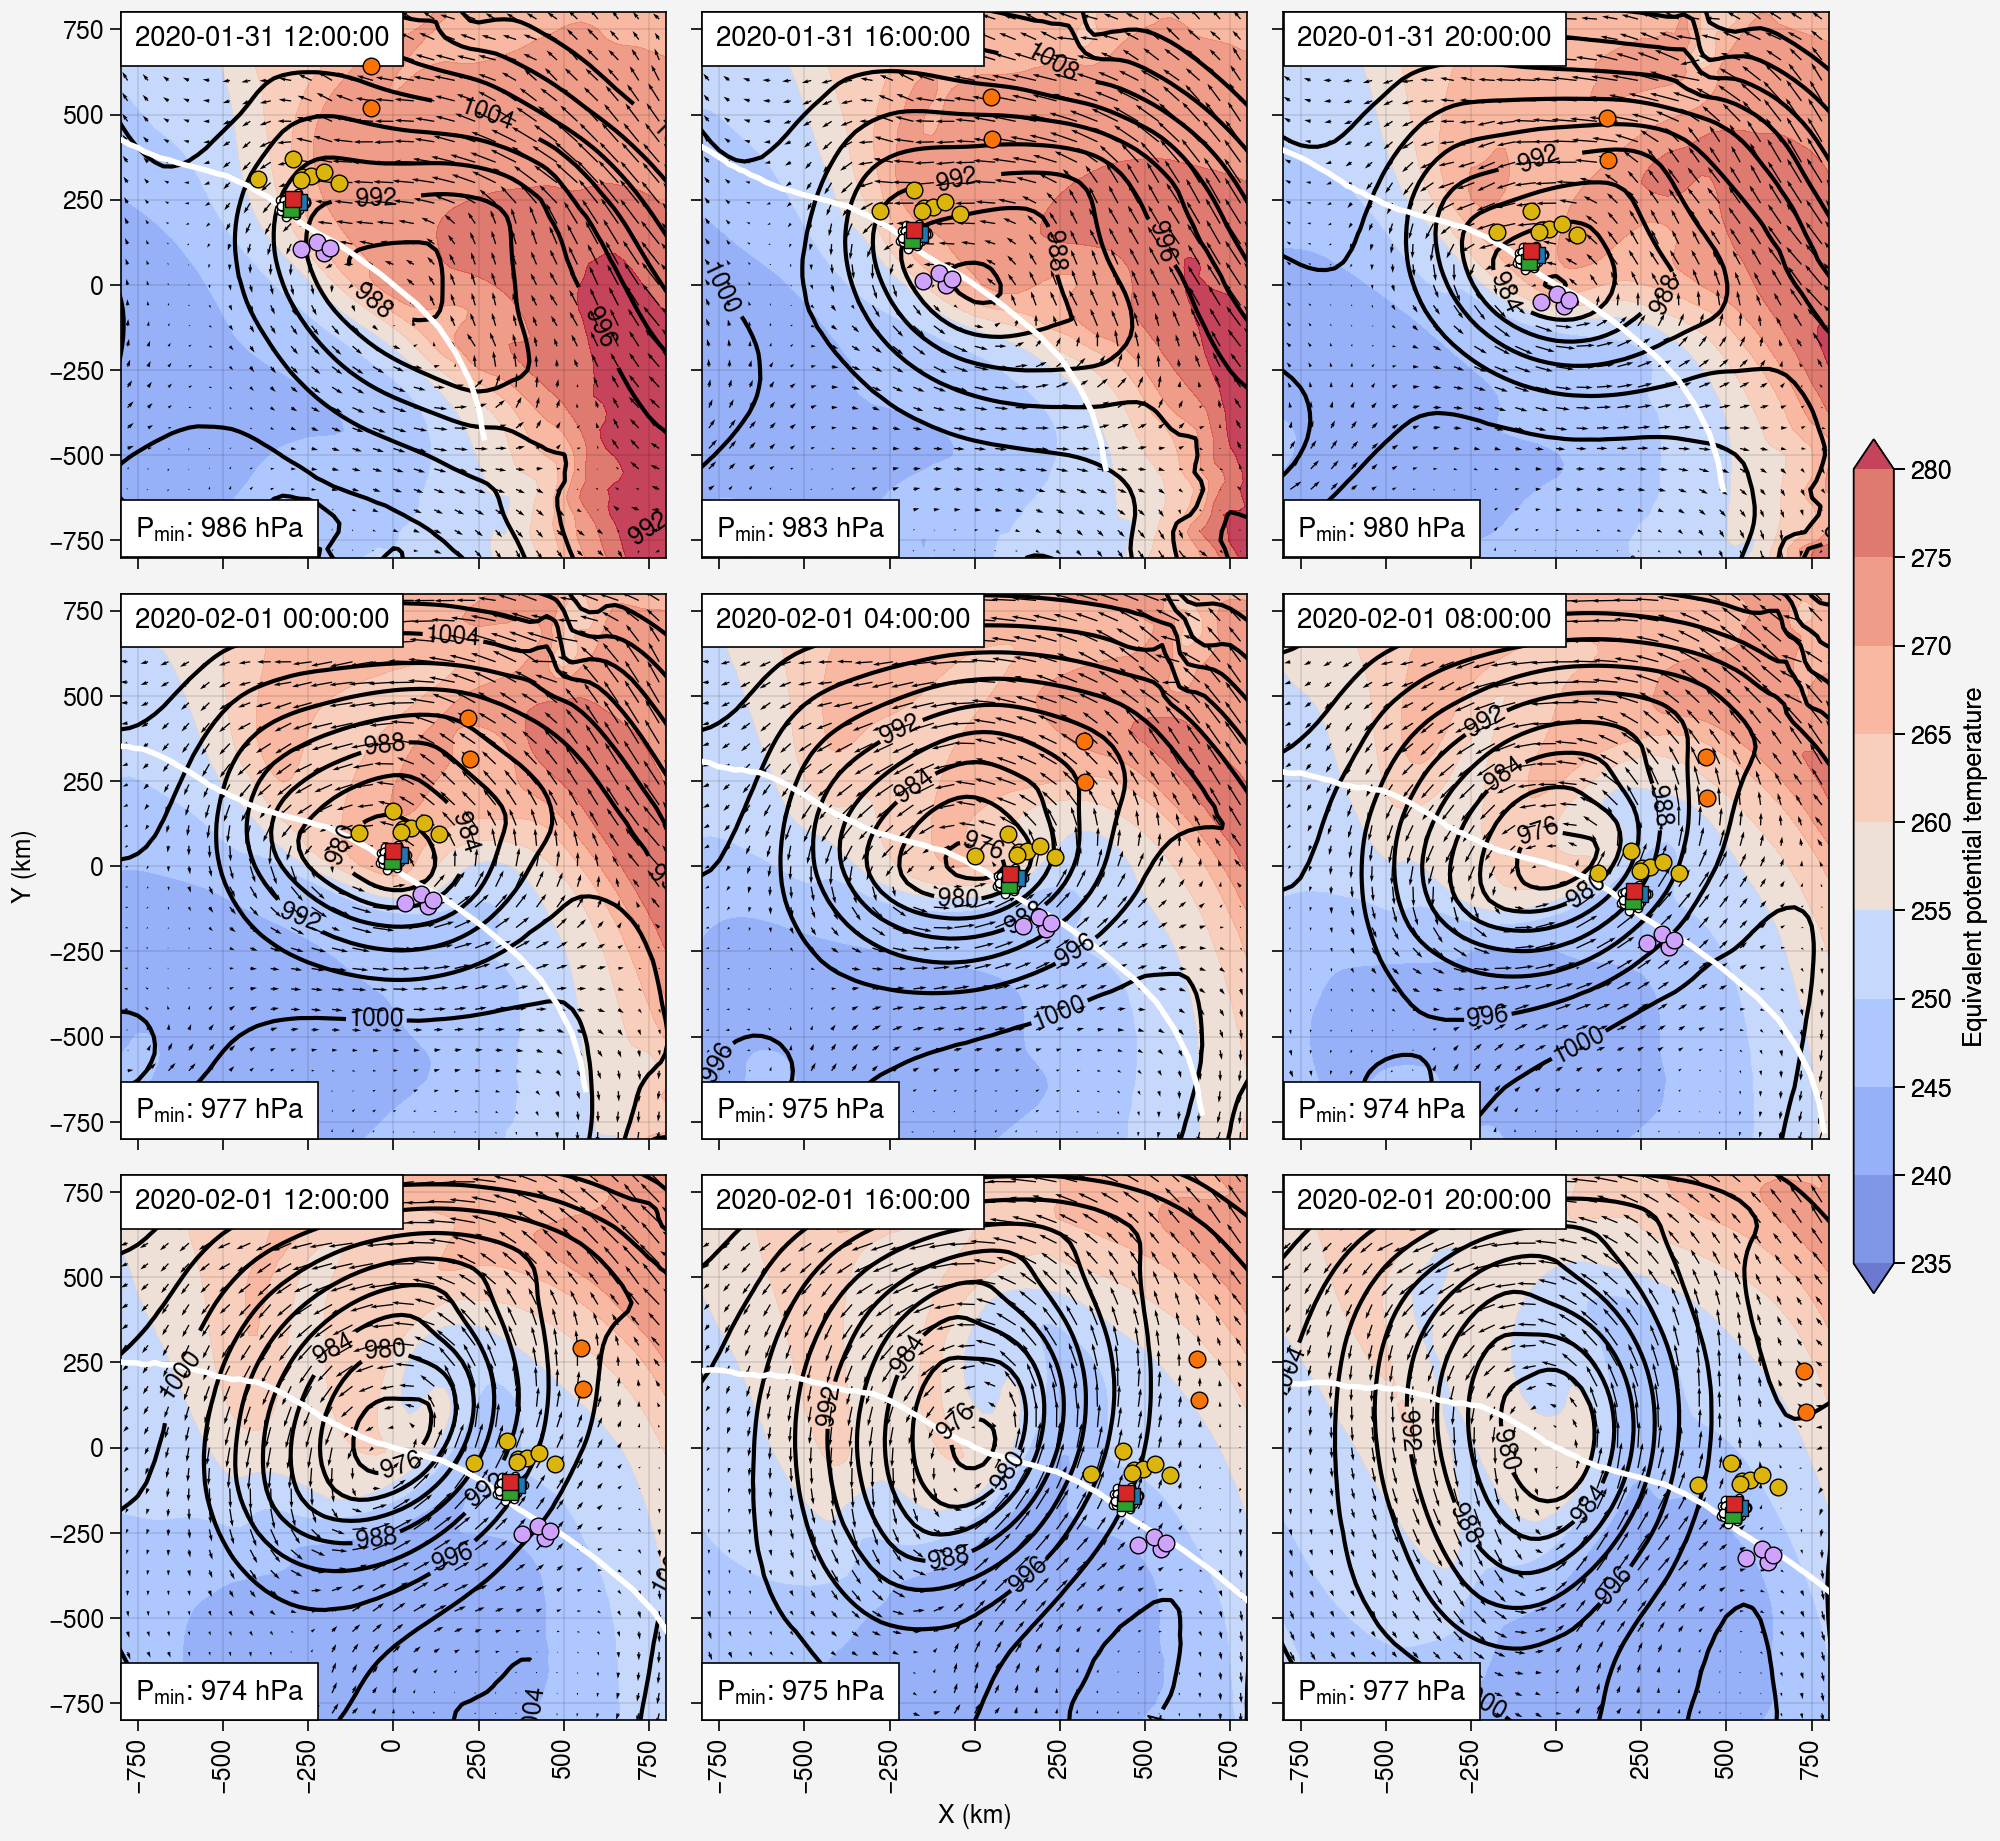

In [149]:
west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites = ['2019T67', '2019T65', '2019S94']
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}


pplt.rc['title.bbox'] = True
pplt.rc['title.bboxalpha'] = 1
pplt.rc['xtick.major.width'] = 0
pplt.rc['ytick.major.width'] = 0
plot_scale = 0.8e3
fig, axs = pplt.subplots(width=10, nrows=3, ncols=3)
local_xu = newu/1e3 #interp_u925['X']/1e3
local_yv = newv/1e3 #interp_u925['Y']/1e3

local_x = interp_p['X']/1e3
local_y = interp_p['Y']/1e3
for date, ax in zip(dates[::4][2:], axs):
    cbar = ax.contourf(local_x, local_y, interp_theta925['Z'][date], levels=np.arange(235, 285, 5),
                   cmap='coolwarm', extend='both', alpha=0.75, cmap_kw={'cut': 0.1})
    ax.contour(local_x, local_y, interp_p['Z'][date], color='k', levels=np.arange(972, 1020, 4),
                   labels=True, zorder=2)
    ax.quiver(local_xu, local_yv,
              interp_u925['Z'][date],
              interp_v925['Z'][date], scale=500)

    ax.format(ultitle=date, ylabel='Y (km)', xlabel='X (km)',
          lltitle='$P_{min}$: ' + str(int(np.round(storm_track.loc[date, 'center_mslp']/100,0))) + ' hPa',
         xlim=(-plot_scale, plot_scale), ylim=(-plot_scale, plot_scale),
          xticks=np.arange(-0.75e3, 0.8e3, 250), xtickminor=False, xrotation=90,
         yticks=np.arange(-0.75e3, 0.8e3, 250), ytickminor=False)
    
    
    for buoy in buoy_data:
        z = 4
        c = 'w'
        m = '.'
        if buoy in west_buoys:
            c = 'lilac'
            m = 'o'
        elif buoy in se_buoys:
            c = 'gold'
            m = 'o'
        elif buoy in far_se_buoys:
            c = 'orange'
            m = 'o'
        elif buoy in l_sites:
            c = l_colors[buoy]
            z = 5
            m = 's'

        if date in buoy_data[buoy].index:
            ax.plot(buoy_data[buoy].loc[date, 'x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
                    buoy_data[buoy].loc[date, 'y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3, zorder=z,
                    edgecolor='k', edgewidth=0.5, marker=m, facecolor=c)

    ax.plot(storm_track['x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
            storm_track['y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3,
            color='w', lw=2, zorder=3)

    
fig.colorbar(cbar, label='Equivalent potential temperature', loc='r', length=0.5)

fig.save('../figures/janfeb_storm_theta_e_u925.png', dpi=300)

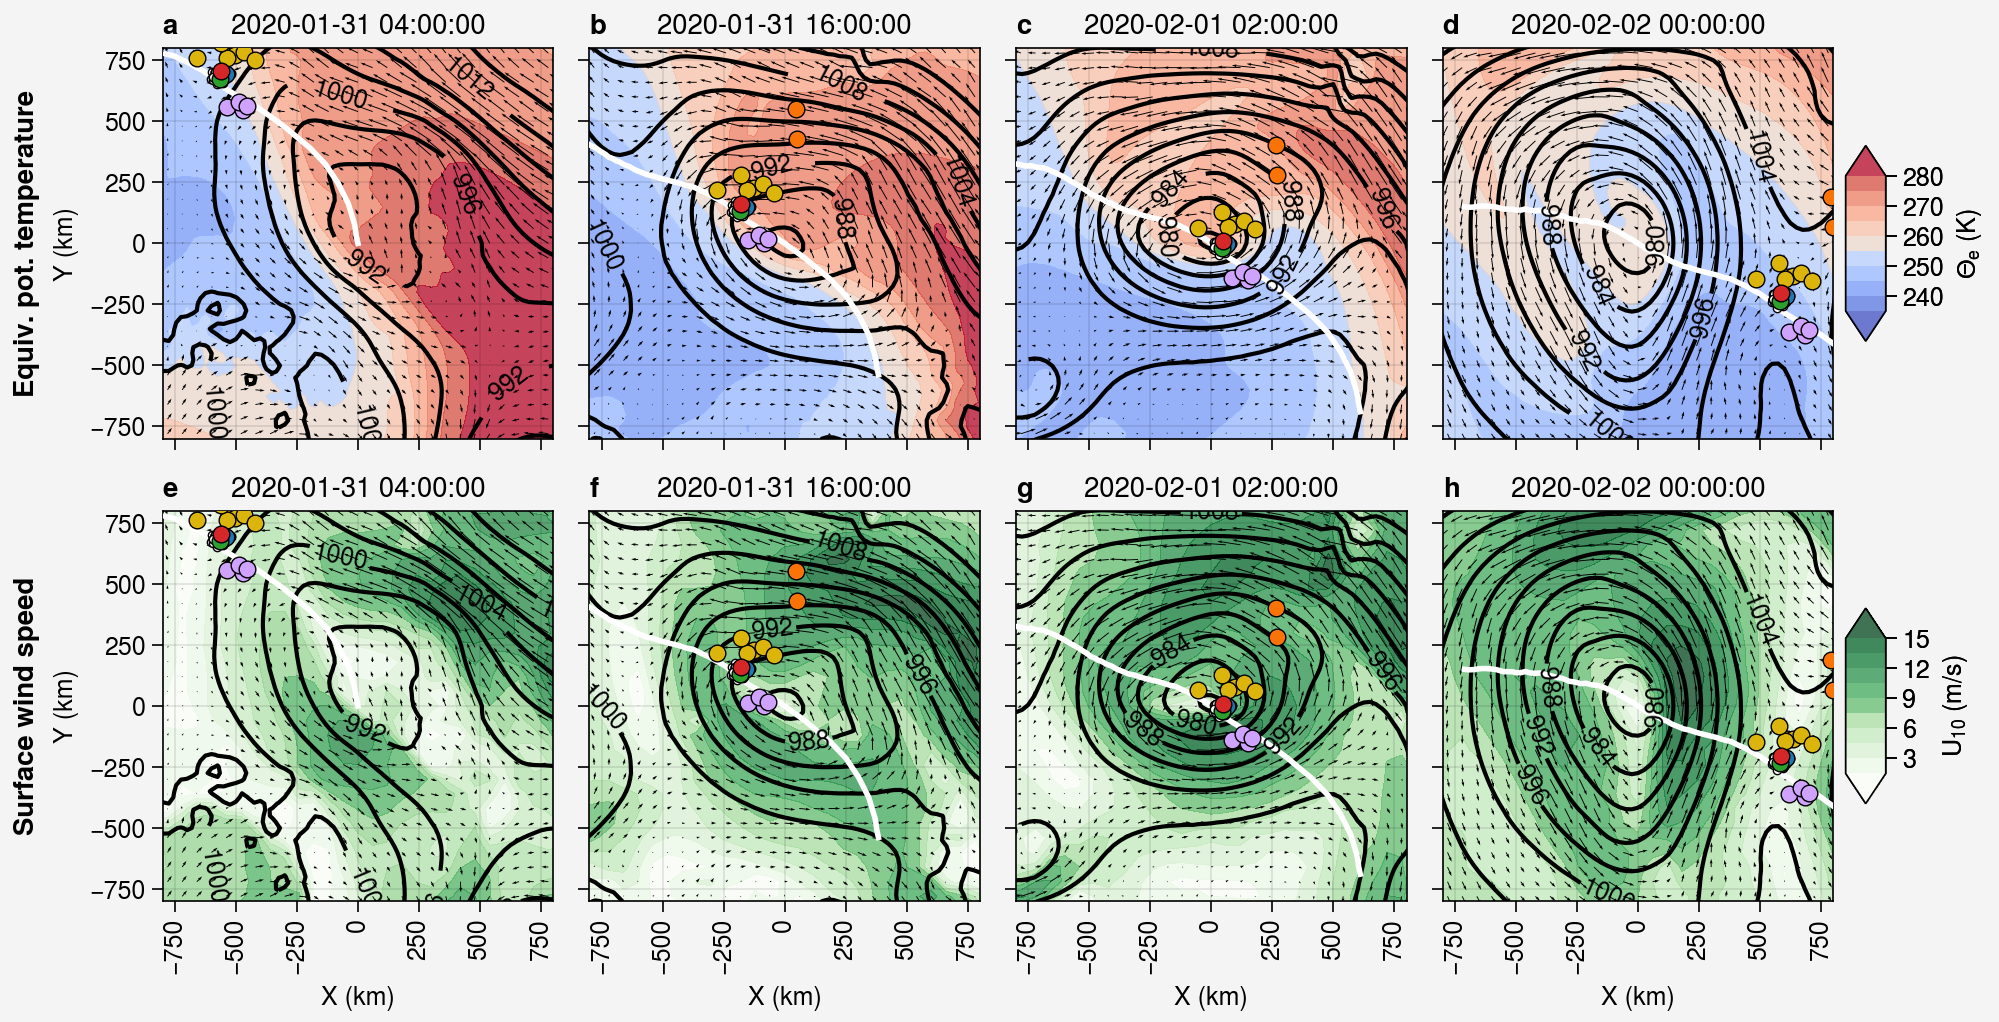

In [150]:
# 2x4 plot with wind speed
west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites = ['2019T67', '2019T65', '2019S94']
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}


pplt.rc['title.bbox'] = True
pplt.rc['title.bboxalpha'] = 1
pplt.rc['xtick.major.width'] = 0
pplt.rc['ytick.major.width'] = 0
plot_scale = 0.8e3
fig, axs = pplt.subplots(width=10, nrows=2, ncols=4, share=True, span=False)
local_xu = newu/1e3 #interp_u925['X']/1e3
local_yv = newv/1e3 #interp_u925['Y']/1e3

local_x = interp_p['X']/1e3
local_y = interp_p['Y']/1e3
plot_dates = ['2020-01-31 04:00', '2020-01-31 16:00', '2020-02-01 02:00', '2020-02-02 0:00']
plot_dates = [pd.to_datetime(x) for x in plot_dates]
for date, ax in zip(plot_dates, axs[0,:]):
    cbar = ax.contourf(local_x, local_y, interp_theta925['Z'][date], levels=np.arange(235, 285, 5),
                   cmap='coolwarm', extend='both', alpha=0.75, cmap_kw={'cut': 0.1})
    ax.contour(local_x, local_y, interp_p['Z'][date], color='k', levels=np.arange(972, 1020, 4),
                   labels=True, zorder=2)
    ax.quiver(local_xu, local_yv,
              interp_u925['Z'][date],
              interp_v925['Z'][date], scale=400)

    ax.format(title=date, ylabel='Y (km)', xlabel='X (km)',
          #lltitle='$P_{min}$: ' + str(int(np.round(storm_track.loc[date, 'center_mslp']/100,0))) + ' hPa',
         xlim=(-plot_scale, plot_scale), ylim=(-plot_scale, plot_scale),
          xticks=np.arange(-0.75e3, 0.8e3, 250), xtickminor=False, xrotation=90,
         yticks=np.arange(-0.75e3, 0.8e3, 250), ytickminor=False)
    
    
    for buoy in buoy_data:
        z = 4
        c = 'w'
        m = '.'
        if buoy in west_buoys:
            c = 'lilac'
            m = 'o'
        elif buoy in se_buoys:
            c = 'gold'
            m = 'o'
        elif buoy in far_se_buoys:
            c = 'orange'
            m = 'o'
        elif buoy in l_sites:
            c = l_colors[buoy]
            z = 5
            m = 'o'

        if date in buoy_data[buoy].index:
            ax.plot(buoy_data[buoy].loc[date, 'x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
                    buoy_data[buoy].loc[date, 'y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3, zorder=z,
                    edgecolor='k', edgewidth=0.5, marker=m, facecolor=c)

    ax.plot(storm_track['x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
            storm_track['y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3,
            color='w', lw=2, zorder=3)
ax.colorbar(cbar, label='$\\Theta_e$ (K)', loc='r', length=0.5)
for date, ax in zip(plot_dates, axs[1,:]):
    U = (interp_u10['Z'][date]**2 + interp_v10['Z'][date]**2)**0.5
    cbar = ax.contourf(local_xu, local_yv, U, #levels=np.arange(0, 20, 10),
                   cmap='greens', extend='both', alpha=0.75, cmap_kw={'cut': 0.1})
    ax.contour(local_x, local_y, interp_p['Z'][date], color='k', levels=np.arange(972, 1020, 4),
                   labels=True, zorder=2)
    ax.quiver(local_xu, local_yv,
              interp_u925['Z'][date],
              interp_v925['Z'][date], scale=400)

    ax.format(title=date, ylabel='Y (km)', xlabel='X (km)',
          #lltitle='$P_{min}$: ' + str(int(np.round(storm_track.loc[date, 'center_mslp']/100,0))) + ' hPa',
         xlim=(-plot_scale, plot_scale), ylim=(-plot_scale, plot_scale),
          xticks=np.arange(-0.75e3, 0.8e3, 250), xtickminor=False, xrotation=90,
         yticks=np.arange(-0.75e3, 0.8e3, 250), ytickminor=False)
    
    
    for buoy in buoy_data:
        z = 4
        c = 'w'
        m = '.'
        if buoy in west_buoys:
            c = 'lilac'
            m = 'o'
        elif buoy in se_buoys:
            c = 'gold'
            m = 'o'
        elif buoy in far_se_buoys:
            c = 'orange'
            m = 'o'
        elif buoy in l_sites:
            c = l_colors[buoy]
            z = 5
            m = 'o'

        if date in buoy_data[buoy].index:
            ax.plot(buoy_data[buoy].loc[date, 'x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
                    buoy_data[buoy].loc[date, 'y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3, zorder=z,
                    edgecolor='k', edgewidth=0.5, marker=m, facecolor=c)

    ax.plot(storm_track['x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
            storm_track['y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3,
            color='w', lw=2, zorder=3)

ax.colorbar(cbar, label='$U_{10}$ (m/s)', loc='r', length=0.5)       
fig.format(abc=True, leftlabels=['Equiv. pot. temperature',  'Surface wind speed'])
fig.save('../figures/janfeb_storm_2x4_theta_wind.png', dpi=300)

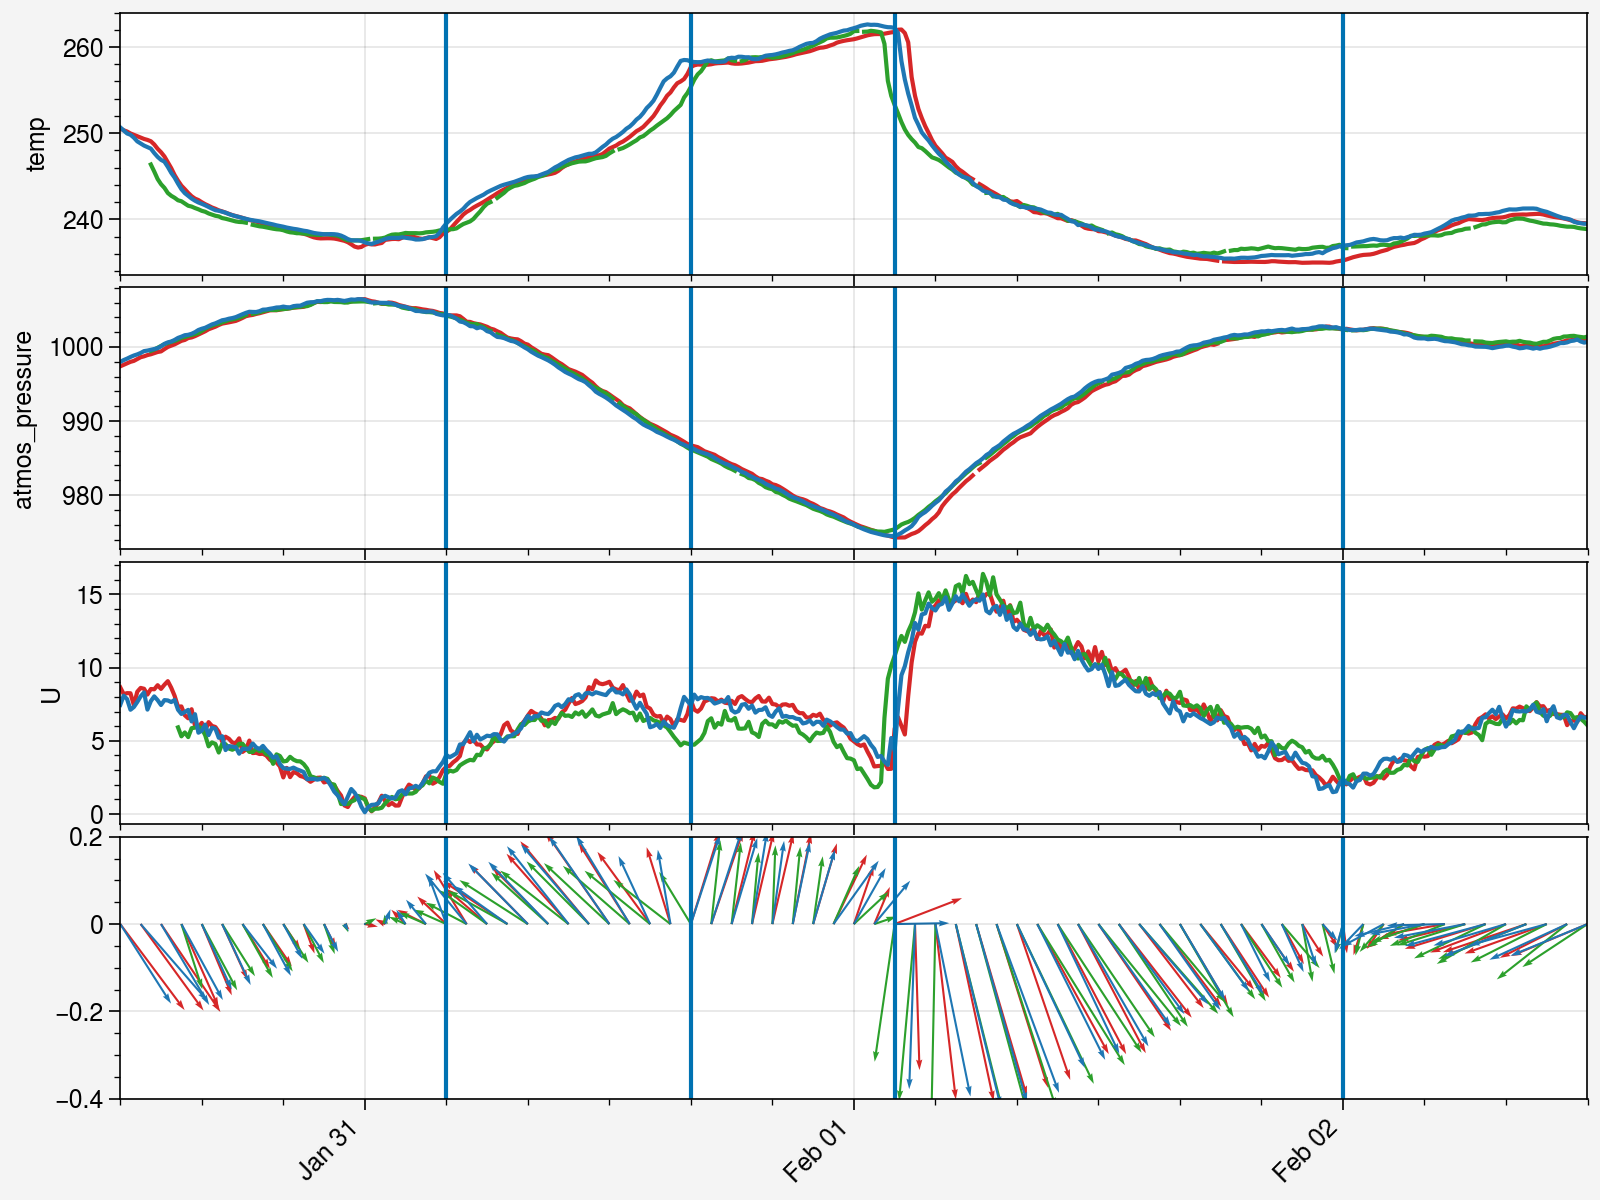

In [50]:


ts = slice('2020-01-30 12:00', '2020-02-02 12:00')
station_name = {'asfs40': 'L1',
                   'asfs30': 'L2', 
                   'asfs50': 'L3'}
colors = {'asfs40': 'tab:blue',
          'asfs30': 'tab:red', 
          'asfs50': 'tab:green'}
fig, axs = pplt.subplots(width=8, height=6, nrows=4, sharey=False, hspace=0.5)
for site, color in zip(['asfs30', 'asfs50', 'asfs40'],
                       ['tab:red', 'tab:blue', 'tab:green']):
    
    df = met_data[site].copy().loc[ts]
    
    df['temp'] = df['temp'].where(df['temp'] > -60) + 273.15
    df['atmos_pressure'] = df['atmos_pressure'].where(df['atmos_pressure'] > 0)

    axs[0].plot(df['temp'], color=colors[site])
    axs[1].plot(df['atmos_pressure'], color=colors[site])
    axs[2].plot(df['U'], color=colors[site])    
    axs[3].quiver(df['wspd_u_mean'].resample('1H').asfreq(),
                 df['wspd_v_mean'].resample('1H').asfreq(),
                 color=colors[site], width=1/700)        
    axs[3].format(ylim=(-0.4, 0.2))
    
axs.format(xminorlocator=1/6, xlabel='', xrotation=45, xformatter='%b %d',
         xlocator='day')
for ax in axs:
    for date in plot_dates:
        ax.axvline(date)
fig.save('../figures/met_data.jpg', dpi=300)

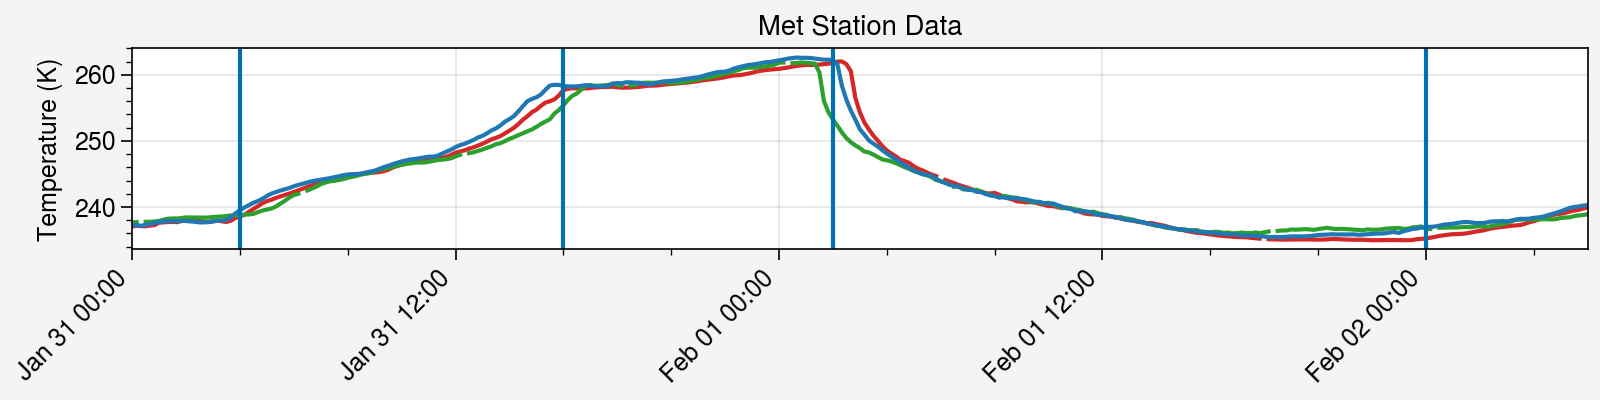

In [51]:
# Temperature only

ts = slice('2020-01-31 0:00', '2020-02-02 06:00')
station_name = {'asfs40': 'L1',
                   'asfs30': 'L2', 
                   'asfs50': 'L3'}
colors = {'asfs40': 'tab:blue',
          'asfs30': 'tab:red', 
          'asfs50': 'tab:green'}
fig, axs = pplt.subplots(width=8, height=2, nrows=1, sharey=False, hspace=0.5)
for site, color in zip(['asfs30', 'asfs50', 'asfs40'],
                       ['tab:red', 'tab:blue', 'tab:green']):
    
    df = met_data[site].copy().loc[ts]
    
    df['temp'] = df['temp'].where(df['temp'] > -60) + 273.15
    df['atmos_pressure'] = df['atmos_pressure'].where(df['atmos_pressure'] > 0)
    axs.plot(df['temp'], color=colors[site])

    
axs.format(xminorlocator=1/6, xlabel='', ylabel='Temperature (K)', title='Met Station Data',
           xrotation=45, xformatter='%b %d %H:%M',
         xlocator=1/2)
for date in plot_dates:
    axs.axvline(date)
fig.save('../figures/met_data_temp.jpg', dpi=300)

Drawing the bounding box: Box borders are at 1000 km from the center of the storm. So for each date, take the x0, y0, add it to the lines, then convert to lat/lon.



In [126]:
colors = [x['color'] for x in pplt.Cycle('colorblind', 3)]
lat_border

array([79.3252824 , 79.34154054, 79.35779233, ..., 73.61172237,
       73.59690354, 73.58207853])

In [ ]:
ds_sic = xr.open_dataset('../data/amsr2_daily_ice_concentration.nc')

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: 

NameError: name 'ds_sic' is not defined

/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/janfeb/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


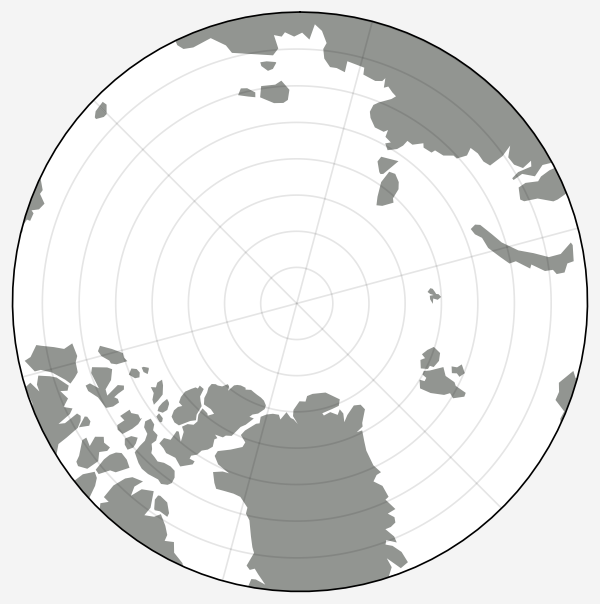

In [57]:
import cartopy.crs as ccrs
fig, ax = pplt.subplots(proj='npstere', width=3, proj_kw={'lon_0': -45})
ax.format(boundinglat=70, land=True, latmax=90, landcolor='gray', oceancolor='white')
sic = ds_sic.sel(time='2020-02-01 00:00')
ax.pcolormesh(sic.longitude, sic.latitude, sic.where((sic.sea_ice_concentration <= 100) &
                                                     (sic.sea_ice_concentration >= 1)).sea_ice_concentration,
          vmin=0, vmax=100, cmap='blues_r', globe=True)
ax.plot(storm_track['lon_smoothed'], storm_track['lat_smoothed'], label='Storm track')
# for buoy in buoy_data:
#     if date in buoy_data[buoy].index:
#         ax.plot(buoy_data[buoy].loc[date, 'longitude'],
#                 buoy_data[buoy].loc[date, 'latitude'], zorder=3,
#                 edgecolor='k', marker='.', facecolor='w')

for date, color in zip(plot_dates, colors):
    x0, y0 = storm_track.loc[date, ['x_stere', 'y_stere']]
    lon0, lat0 = storm_track.loc[date, ['lon_smoothed', 'lat_smoothed']]    
    n = 1000
    # X locations, Y locations
    borders = np.hstack([
            np.vstack([x0-1e6*np.ones(n), y0+np.linspace(-1e6, 1e6, n)]), # left
            np.vstack([x0+np.linspace(-1e6, 1e6, n), y0+1e6*np.ones(n)]), # top
            np.vstack([x0+1e6*np.ones(n), y0+np.linspace(-1e6, 1e6, n)]), # right
            np.vstack([x0+np.linspace(-1e6, 1e6, n), y0-1e6*np.ones(n)])]) # bottom
    lon_border, lat_border = polar_to_latlon.transform(borders[0,:], borders[1,:])
    ax.scatter(lon_border, lat_border, s=3, label='', c=color, zorder=4, transform=ccrs.PlateCarree())
    ax.scatter(lon0, lat0, s=15, label=date, c=color, zorder=5)
    
fig.legend(loc='b', ncols=1)
fig.save('../figures/reference_map.jpg', dpi=300)

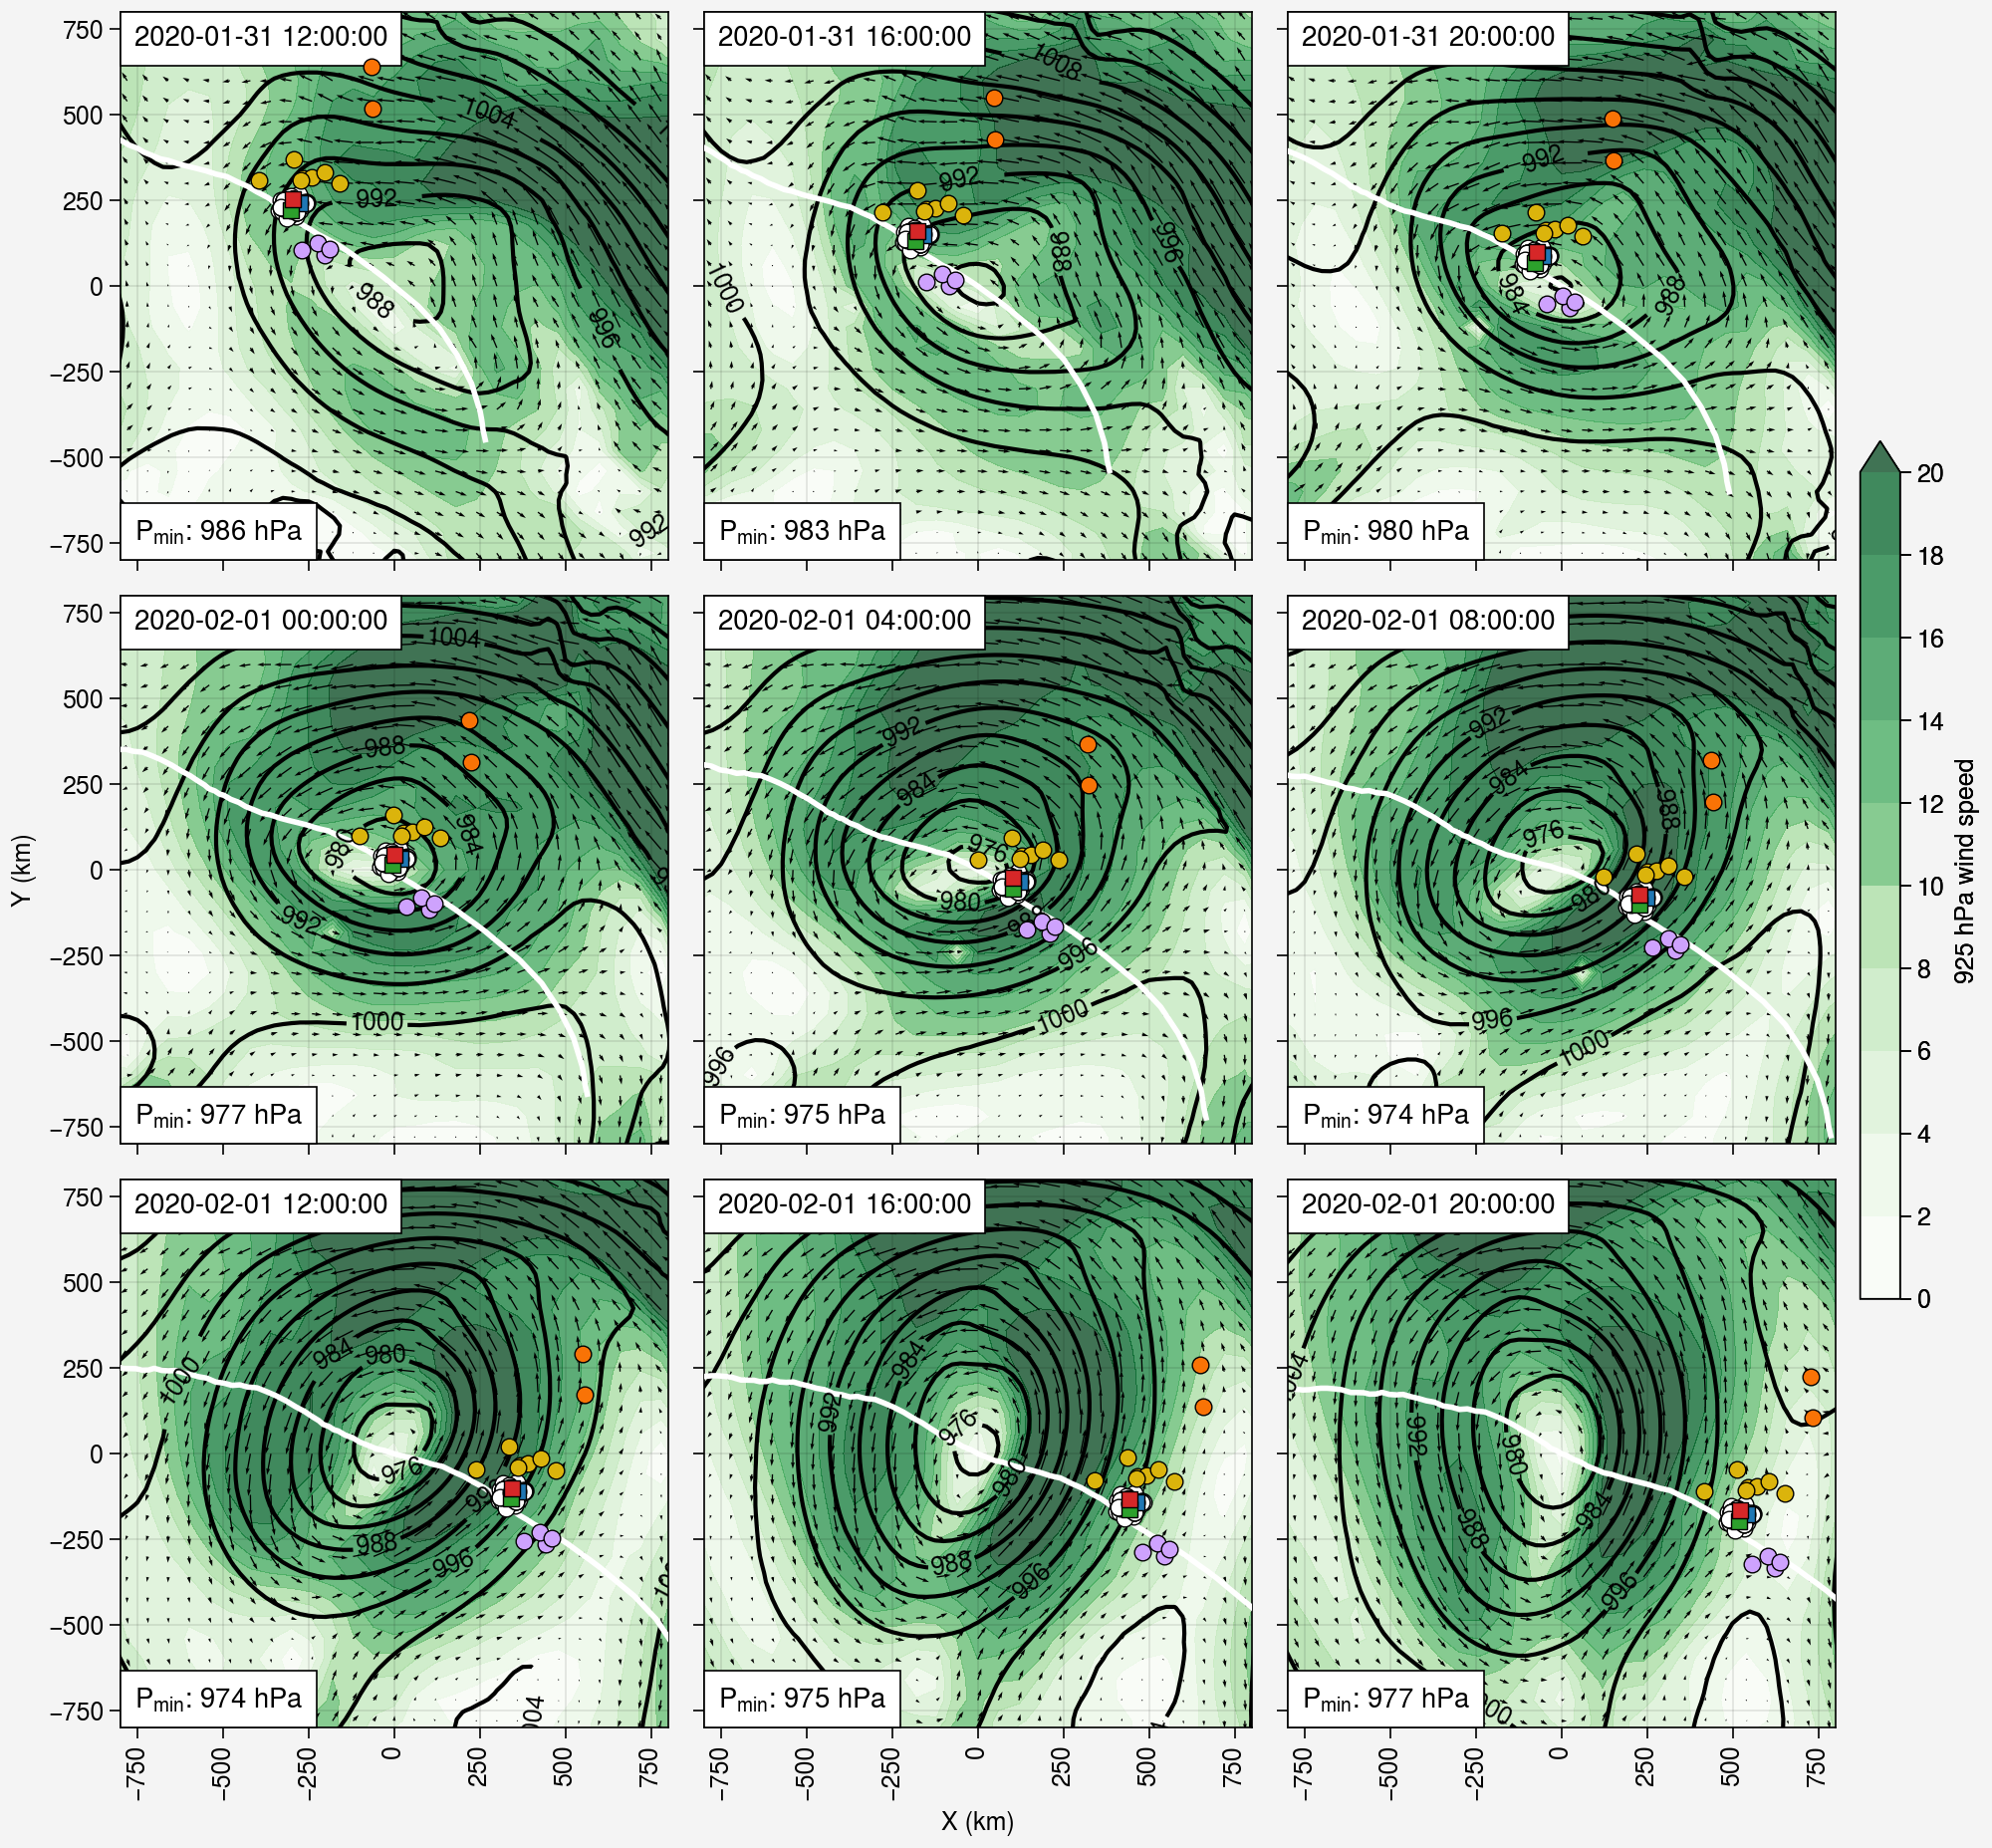

In [155]:
west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites = ['2019T67', '2019T65', '2019S94']
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}


pplt.rc['title.bbox'] = True
pplt.rc['title.bboxalpha'] = 1
pplt.rc['xtick.major.width'] = 0
pplt.rc['ytick.major.width'] = 0
plot_scale = 0.8e3
fig, axs = pplt.subplots(width=10, nrows=3, ncols=3)
local_xu = newu/1e3 #interp_u925['X']/1e3
local_yv = newv/1e3 #interp_u925['Y']/1e3

local_x = interp_p['X']/1e3
local_y = interp_p['Y']/1e3
for date, ax in zip(dates[::4][2:], axs):
    U = (interp_u925['Z'][date]**2 + interp_v925['Z'][date]**2)**0.5
    cbar = ax.contourf(local_xu, local_yv, U, levels=np.arange(0, 21, 2),
                   cmap='greens', extend='max', alpha=0.75, cmap_kw={'cut': 0.1})
    
    ax.contour(local_x, local_y, interp_p['Z'][date], color='k', levels=np.arange(972, 1020, 4),
                   labels=True, zorder=2)
    ax.quiver(local_xu, local_yv,
              interp_u925['Z'][date],
              interp_v925['Z'][date], scale=500)

    ax.format(ultitle=date, ylabel='Y (km)', xlabel='X (km)',
          lltitle='$P_{min}$: ' + str(int(np.round(storm_track.loc[date, 'center_mslp']/100,0))) + ' hPa',
         xlim=(-plot_scale, plot_scale), ylim=(-plot_scale, plot_scale),
          xticks=np.arange(-0.75e3, 0.8e3, 250), xtickminor=False, xrotation=90,
         yticks=np.arange(-0.75e3, 0.8e3, 250), ytickminor=False)
    
    
    for buoy in buoy_data:
        z = 4
        c = 'w'
        m = 'o'
        if buoy in west_buoys:
            c = 'lilac'
            m = 'o'
        elif buoy in se_buoys:
            c = 'gold'
            m = 'o'
        elif buoy in far_se_buoys:
            c = 'orange'
            m = 'o'
        elif buoy in l_sites:
            c = l_colors[buoy]
            z = 5
            m = 's'

        if date in buoy_data[buoy].index:
            ax.plot(buoy_data[buoy].loc[date, 'x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
                    buoy_data[buoy].loc[date, 'y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3, zorder=z,
                    edgecolor='k', edgewidth=0.5, marker=m, facecolor=c)

    ax.plot(storm_track['x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
            storm_track['y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3,
            color='w', lw=2, zorder=3)

    
fig.colorbar(cbar, label='925 hPa wind speed', loc='r', length=0.5)

fig.save('../figures/janfeb_storm_U925_msl.png', dpi=300)

In [85]:
df_lon = pd.DataFrame({buoy: buoy_data[buoy]['longitude'] for buoy in buoy_data})
df_lat = pd.DataFrame({buoy: buoy_data[buoy]['latitude'] for buoy in buoy_data})
df_x = pd.DataFrame({buoy: buoy_data[buoy]['x_stere'] for buoy in buoy_data})
df_y = pd.DataFrame({buoy: buoy_data[buoy]['y_stere'] for buoy in buoy_data})
df_u = pd.DataFrame({buoy: buoy_data[buoy]['u_stere'] for buoy in buoy_data})
df_v = pd.DataFrame({buoy: buoy_data[buoy]['v_stere'] for buoy in buoy_data})

In [2]:
sw_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
ne_buoys = ['2019P155', '2019P123', '2019P156', '2019P157']

west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114',
            '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites = ['2019T67', '2019T65', '2019S94']

In [ ]:
date = '2020-02-01 00:00'
df_y.loc[date].sort_values().tail(10).index

In [84]:
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].loc[:, ['latitude', 'longitude']]
    buoy_df = anls.compute_velocity(buoy_df, rotate_uv=False, method='centered', date_index=True)
    buoy_data[buoy]['u_stere'] = buoy_df['u']
    buoy_data[buoy]['v_stere'] = buoy_df['v']
    

In [116]:
l_sites

['2019T67', '2019T65', '2019S94']

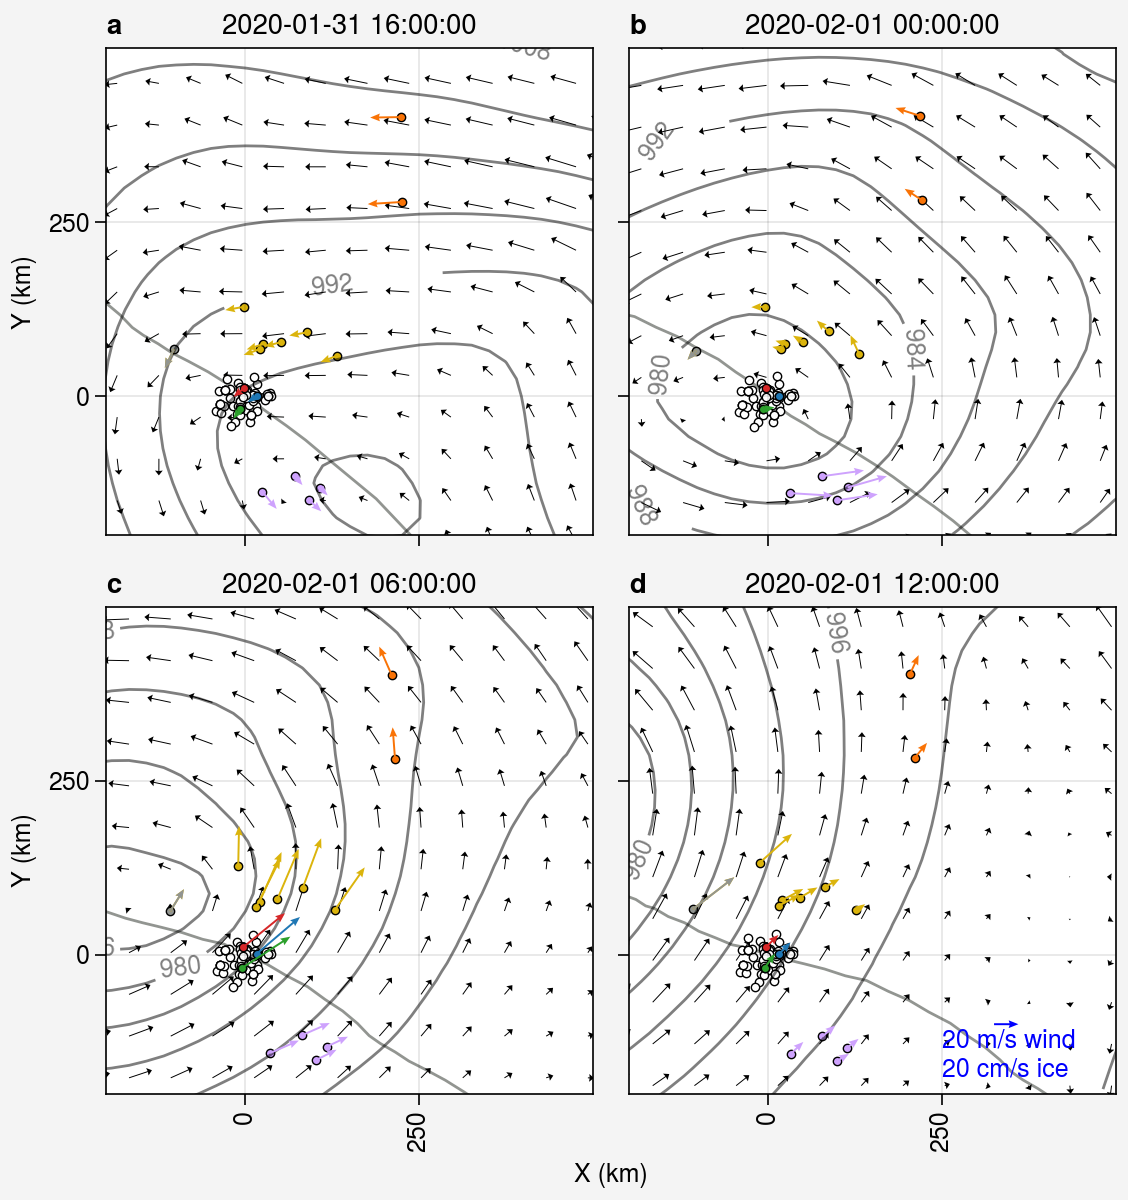

In [143]:


pplt.rc['title.bbox'] = True
pplt.rc['title.bboxalpha'] = 1
pplt.rc['xtick.major.width'] = 0
pplt.rc['ytick.major.width'] = 0

fig, axs = pplt.subplots(height=6, nrows=2, ncols=2, share=True, spany=False)
# these values are centered on the storm track
zoom_plot_dates =  ['2020-01-31 16:00', '2020-02-01 0:00', '2020-02-01 06:00', '2020-02-01 12:00']
zoom_plot_dates = [pd.to_datetime(x) for x in zoom_plot_dates]
for date, ax in zip(zoom_plot_dates, axs):
    x0 = storm_track.loc[date, 'x_stere']/1e3
    y0 = storm_track.loc[date, 'y_stere']/1e3
    x_dn = df_x.loc[date, '2019T66']/1e3
    y_dn = df_y.loc[date, '2019T66']/1e3
    local_xu = newu/1e3 + x0 - x_dn
    local_yv = newv/1e3 + y0 - y_dn
    local_x = interp_p['X']/1e3 + x0 - x_dn
    local_y = interp_p['Y']/1e3 + y0 - y_dn

    ax.contour(local_x, local_y, interp_p['Z'][date], color='k', levels=np.arange(972, 1020, 4),
                   labels=True, zorder=2, lw=1, alpha=0.5)
    ax.quiver(local_xu, local_yv,
              interp_u925['Z'][date],
              interp_v925['Z'][date], scale=400, headwidth=8, width=1/500)

    ax.format(title=date, ylabel='Y (km)', xlabel='X (km)',
          #lltitle='$P_{min}$: ' + str(int(np.round(storm_track.loc[date, 'center_mslp']/100,0))) + ' hPa',
         ylim=(-0.2e3, 0.5e3), xlim=(-0.2e3, 0.5e3),
          xticks=np.arange(-0.25e3, 0.26e3, 250), xtickminor=False, xrotation=90,
         yticks=np.arange(-0.25e3, 0.26e3, 250), ytickminor=False)
    for buoy in buoy_data:
        if date in buoy_data[buoy].index:
            z = 1
            m = '.'
            if buoy in west_buoys:
                c = 'lilac'
            elif buoy in se_buoys:
                c = 'gold'
            elif buoy in far_se_buoys:
                c = 'orange'
            elif buoy in l_sites:
                c = l_colors[buoy]
                z = 5
                m = '.'
            else:
                c='w'
            if buoy == '2019P22':
                c = 'gray'
            ax.plot(buoy_data[buoy].loc[date, 'x_stere']/1e3 - x_dn,
                    buoy_data[buoy].loc[date, 'y_stere']/1e3 - y_dn,
                    edgecolor='k', edgewidth=0.5, marker=m, facecolor=c, zorder=z)
    for color, buoy_set in zip(['lilac', 'gold', 'orange',
                                'tab:blue', 'tab:red', 'tab:green', 'gray'],
                               [west_buoys, se_buoys, far_se_buoys,
                                ['2019T67'], ['2019T65'], ['2019S94'], ['2019P22']]):
        ax.quiver(df_x.loc[date, buoy_set]/1e3  - x_dn,
                  df_y.loc[date, buoy_set]/1e3 - y_dn,
                  df_u.loc[date, buoy_set]*100,
                  df_v.loc[date, buoy_set]*100,
                  scale=400, headwidth=4, c = color, zorder=6, width=1/250)

    ax.plot(storm_track['x_stere']/1e3 - storm_track.loc[date, 'x_stere']/1e3,
            storm_track['y_stere']/1e3 - storm_track.loc[date, 'y_stere']/1e3,
            color='gray', lw=1, zorder=0)

ax.quiver(325,
          -100,
          20,
          0,
          scale=400, headwidth=4, c = 'b', zorder=6, width=1/250)
ax.text(250, -175, '20 m/s wind\n20 cm/s ice', c='b')
fig.format(xreverse=False, yreverse=False, abc=True)
fig.save('../figures/janfeb_storm_zoom_buoys.jpg', dpi=300)

In [1]:
fig, ax = pplt.subplots(nrows=3, ncols=4, share=False)
ts = slice('2020-01-30 12:00', '2020-02-01 20:00')
for idx, buoy in enumerate(ne_buoys):
    ax[0, idx].plot(buoy_data[buoy].loc[ts, 'x_stere'],
                    buoy_data[buoy].loc[ts, 'y_stere'], color='gold')
    ax[0, idx].format(ultitle=buoy, urtitle=metadata.loc[buoy, 'DN Station ID'])    
    for date in plot_dates:
        x0, y0 = storm_track.loc[date, ['x_stere', 'y_stere']]    
        ax[0,idx].plot(buoy_data[buoy].loc[date, 'x_stere'],
                buoy_data[buoy].loc[date, 'y_stere'], label=date,
               marker='o', lw=0)
    ax.format(yreverse=False, xreverse=False)

for idx, buoy in enumerate(sw_buoys):
    ax[2, idx].plot(buoy_data[buoy].loc[ts, 'x_stere'],
                    buoy_data[buoy].loc[ts, 'y_stere'], color='lilac')
    ax[2, idx].format(ultitle=buoy, urtitle=metadata.loc[buoy, 'DN Station ID'])
    for date in plot_dates:
        x0, y0 = storm_track.loc[date, ['x_stere', 'y_stere']]    
        ax[2,idx].plot(buoy_data[buoy].loc[date, 'x_stere'],
                buoy_data[buoy].loc[date, 'y_stere'], label=date,
               marker='o', lw=0)
    ax.format(yreverse=False, xreverse=False)

for idx, buoy in enumerate(l_sites):
    ax[1, idx].plot(buoy_data[buoy].loc[ts, 'x_stere'],
                    buoy_data[buoy].loc[ts, 'y_stere'], color='r')
    for date in plot_dates:
        x0, y0 = storm_track.loc[date, ['x_stere', 'y_stere']]    
        ax[1,idx].plot(buoy_data[buoy].loc[date, 'x_stere'],
                buoy_data[buoy].loc[date, 'y_stere'], label=date,
               marker='o', lw=0)
    ax.format(yreverse=False, xreverse=False)

    ax[1, idx].format(ultitle=buoy, urtitle=metadata.loc[buoy, 'DN Station ID'])    
    
ax[-1].legend(loc='r', ncols=1)
fig.save('../figures/tracks_near_and_far.jpg', dpi=300)

NameError: name 'pplt' is not defined